# Mandelbrot

Mandelbrot dataset. Draw with various optimizations

In [1]:
# Import various libraries

import numpy as np
from pylab import imshow, show
from timeit import default_timer as timer
from numba import jit, njit, prange, cuda
from multiprocessing import Pool


In [2]:
# drawing settings

iters = 250
min_x = -2.0
max_x = 1.0
min_y = -1.0
max_y = 1.0


## No Optimization

Run with no optimization in serial order of drawing

In [3]:
def mandel_no_op(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z ** 2 + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return max_iters


In [4]:
def create_fractal_no_op(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height

    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel_no_op(real, imag, iters)
            image[y, x] = color


Mandelbrot created in 21.817561 s


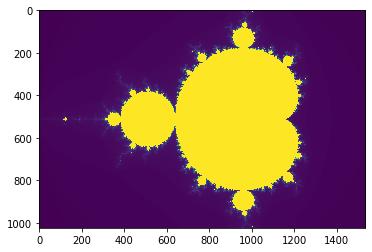

In [5]:
image = np.zeros((1024, 1536), dtype = np.uint8)
start = timer()
create_fractal_no_op(min_x, max_x, min_y, max_y, image, iters) 
dt = timer() - start

print("Mandelbrot created in %f s" % dt)
imshow(image)
show()


## JIT optimization

Optimize with numba and JIT (just in time) compiling of code (instead of interpreted as python is normally run)

In [6]:
@jit
def mandel_jit(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z ** 2 + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return max_iters


In [7]:
@jit
def create_fractal_jit(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height

    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel_jit(real, imag, iters)
            image[y, x] = color


Mandelbrot created in 0.537854 s


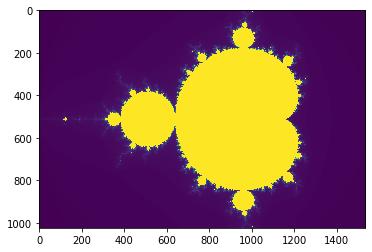

In [8]:
image = np.zeros((1024, 1536), dtype = np.uint8)
start = timer()
create_fractal_jit(min_x, max_x, min_y, max_y, image, iters) 
dt = timer() - start

print("Mandelbrot created in %f s" % dt)
imshow(image)
show()


## Parallel Optimization

optimize creating fractal by distributing processing each thread accross multiple processes

In [9]:
@jit(fastmath=True)
def mandel_fastmath(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    c = complex(x, y)
    z = 0.0j
    for i in prange(max_iters):
        z = z ** 2 + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return max_iters


In [10]:
@njit(parallel=True)
def create_fractal_parallel(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    
    for x in prange(width):
        real = min_x + x * pixel_size_x
        for y in prange(height):
            imag = min_y + y * pixel_size_y
            color = mandel_fastmath(real, imag, iters)
            image[y, x] = color


Mandelbrot created in 0.358107 s


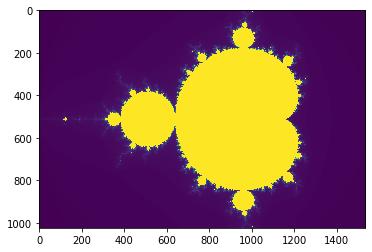

In [11]:
image = np.zeros((1024, 1536), dtype = np.uint8)
start = timer()
create_fractal_parallel(min_x, max_x, min_y, max_y, image, iters) 
dt = timer() - start

print("Mandelbrot created in %f s" % dt)
imshow(image)
show()


In [12]:
create_fractal_parallel.parallel_diagnostics(level=4)

 
 Parallel Accelerator Optimizing:  Function create_fractal_parallel, <ipython-
input-10-65ddda4ac867> (1)  


Parallel loop listing for  Function create_fractal_parallel, <ipython-input-10-65ddda4ac867> (1) 
--------------------------------------------------------------------------|loop #ID
@njit(parallel=True)                                                      | 
def create_fractal_parallel(min_x, max_x, min_y, max_y, image, iters):    | 
    height = image.shape[0]                                               | 
    width = image.shape[1]                                                | 
                                                                          | 
    pixel_size_x = (max_x - min_x) / width                                | 
    pixel_size_y = (max_y - min_y) / height                               | 
                                                                          | 
    for x in prange(width):-----------------------------------------------| #1
        rea

# Cuda Optimization 

optimize by using cuda library

In [13]:
@cuda.jit(device=True)
def mandel_cuda(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    c = complex(x, y)
    z = 0.0j
    for i in prange(max_iters):
        z = z ** 2 + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return max_iters


In [14]:
@cuda.jit
def create_fractal_cuda(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel_cuda(real, imag, iters)
            image[y, x] = color


In [17]:
gimage = np.zeros((1024, 1536), dtype = np.uint8)
start = timer()
create_fractal_cuda(min_x, max_x, min_y, max_y, gimage, iters) 
dt = timer() - start

print("Mandelbrot created in %f s" % dt)
imshow(image)
show()


CudaSupportError: Error at driver init: 
[100] Call to cuInit results in CUDA_ERROR_NO_DEVICE: